### SCHOOL DROP-OUT RISK PREDECTION 

# 1. Import libraries 

In [16]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import joblib
import warnings
warnings.filterwarnings('ignore')

# 2. Simulate the dataset

In [101]:
np.random.seed(42)
n = 800  # number of students

data = pd.DataFrame({
    'student_id': range(1, n+1),
    'grade_level': np.random.randint(1, 13, n),
    'attendance_pct': np.clip(np.random.normal(85, 10, n), 40, 100).astype(int),
    'grades_avg': np.clip(np.random.normal(70, 15, n), 30, 100).astype(int),
    'discipline_count': np.random.poisson(1, n),
    'clubs_participation': np.random.choice([0,1], n, p=[0.6,0.4]),
    'family_support': np.random.randint(1,6, n),
    'hours_study_per_week': np.clip(np.random.normal(8, 4, n), 0, 20).round(1)
})

# Risk of dropping out: 1 (high risk) to 0 (low risk)
data['dropout_risk'] = (
    (data['attendance_pct'] < 70).astype(int) |
    (data['grades_avg'] < 40).astype(int) |
    (data['discipline_count'] > 3).astype(int) |
    (data['family_support'] < 3).astype(int)
).astype(int)
data['dropout_risk'] = data['dropout_risk'].apply(lambda x: 1 if x >= 1 else 0)
data.to_csv('student_dropout_data.csv', index=False)

In [102]:
# Label (dropout or not)
data['dropout'] = (
    (data['attendance_pct'] < 70) &
    (data['grades_avg'] < 60) &
    (data['family_support'] < 3)
).astype(int)

In [104]:
print("✅ Student Data Sample:")
display(data.head(50))

✅ Student Data Sample:


,student_id,grade_level,attendance_pct,grades_avg,discipline_count,clubs_participation,family_support,hours_study_per_week,dropout_risk,dropout
0,1,7,94,72,1,0,5,9.6,0,0
1,2,4,93,73,0,1,1,10.4,1,0
2,3,11,71,45,0,0,4,19.1,0,0
3,4,8,78,75,0,1,2,8.2,1,0
4,5,5,78,86,0,0,4,5.1,0,0
5,6,7,77,56,2,1,4,0.0,0,0
6,7,10,76,76,0,1,3,3.2,0,0
7,8,3,78,83,0,0,3,12.9,0,0
8,9,7,88,78,0,0,4,10.9,0,0
9,10,11,89,80,1,0,2,2.6,1,0


In [105]:
# Check for missing values
print("\n✅ Missing Values:\n", data.isnull().sum())


✅ Missing Values:
 student_id              0
grade_level             0
attendance_pct          0
grades_avg              0
discipline_count        0
clubs_participation     0
family_support          0
hours_study_per_week    0
dropout_risk            0
dropout                 0
dtype: int64


In [106]:
# Check for duplicates
print("\n✅ Duplicate Rows:", data.duplicated().sum())



✅ Duplicate Rows: 0


### 3. Feature Engineering

In [107]:
# Create a new feature 'risk_score' as a weighted index
data['risk_score'] = (100-data['attendance_pct']) * 0.3 + (100-data['grades_avg']) * 0.6 + (5 - data['family_support']) * 0.1 + data['discipline_count'] * 5
data['risk_score'] = data['risk_score'].clip(0, 100).round(1)

Insights
- The risk_score is a weighted index (out of 100) combining multiple behavioral and academic indicattors.
- Low attendance means high risk(30% weighted)
- Low grades means high risk of dropping out (40%)
- Low family support means high risk (10%)
- High discipline cases mean higher risk of dropping out(Each disciplinary incident adds +5 points to risk)

In [109]:
# Categorize the risk
data['risk_level'] = pd.cut(data['risk_score'], bins=[0, 30, 60, 100], labels=['Low', 'Medium', 'High'])

In [111]:
data.head(10)

,student_id,grade_level,attendance_pct,grades_avg,discipline_count,clubs_participation,family_support,hours_study_per_week,dropout_risk,dropout,risk_score,risk_level
0,1,7,94,72,1,0,5,9.6,0,0,23.6,Low
1,2,4,93,73,0,1,1,10.4,1,0,18.7,Low
2,3,11,71,45,0,0,4,19.1,0,0,41.8,Medium
3,4,8,78,75,0,1,2,8.2,1,0,21.9,Low
4,5,5,78,86,0,0,4,5.1,0,0,15.1,Low
5,6,7,77,56,2,1,4,0.0,0,0,43.4,Medium
6,7,10,76,76,0,1,3,3.2,0,0,21.8,Low
7,8,3,78,83,0,0,3,12.9,0,0,17.0,Low
8,9,7,88,78,0,0,4,10.9,0,0,16.9,Low
9,10,11,89,80,1,0,2,2.6,1,0,20.6,Low


### 4. EDA (Exploratory Data Analysis)

In [125]:
data.describe()

,student_id,grade_level,attendance_pct,grades_avg,discipline_count,clubs_participation,family_support,hours_study_per_week,dropout_risk,dropout,risk_score
count,800.0000,800.000000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,6.488750,85.067500,69.43125,1.017500,0.392500,3.080000,8.129500,0.466250,0.003750,28.100500
std,231.0844,3.542324,9.852882,14.39946,1.023965,0.488613,1.403054,3.806493,0.499172,0.061161,10.546933
min,1.0000,1.000000,57.000000,30.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.900000
25%,200.7500,3.000000,78.000000,59.00000,0.000000,0.000000,2.000000,5.475000,0.000000,0.000000,20.575000
50%,400.5000,6.500000,85.000000,70.00000,1.000000,0.000000,3.000000,8.000000,0.000000,0.000000,27.600000
75%,600.2500,10.000000,93.000000,80.00000,2.000000,1.000000,4.000000,10.700000,1.000000,0.000000,35.200000
max,800.0000,12.000000,100.000000,100.00000,5.000000,1.000000,5.000000,20.000000,1.000000,1.000000,58.100000


Text(0.5, 1.0, 'Dropout Distribution by Grade Level')

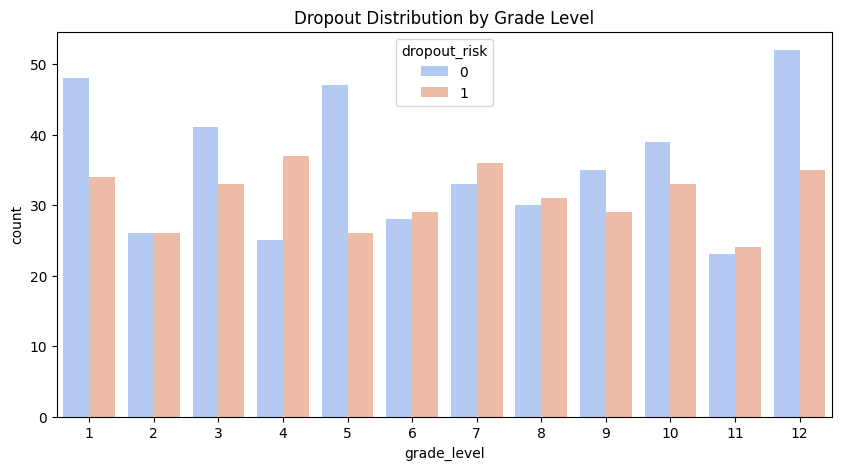

In [122]:
data['dropout_risk'].value_counts()
plt.figure(figsize=(10,5))
sns.countplot(x='grade_level', hue='dropout_risk', data=data, palette='coolwarm')
plt.title("Dropout Distribution by Grade Level")

Text(0.5, 1.0, 'Attendance vs Dropout')

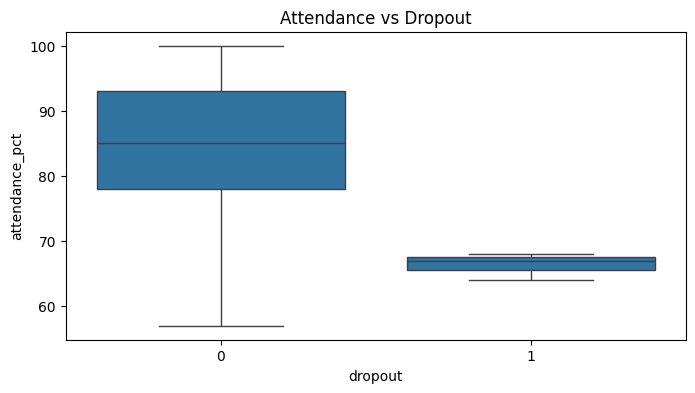

In [123]:
data['dropout'].value_counts()
plt.figure(figsize=(8,4))  
sns.boxplot(x='dropout', y='attendance_pct', data=data)
plt.title("Attendance vs Dropout")

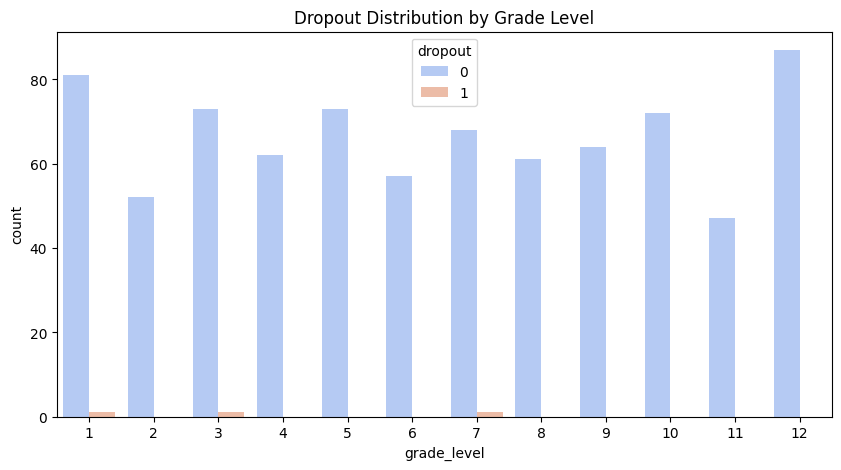

In [114]:
plt.figure(figsize=(10,5))
sns.countplot(x='grade_level', hue='dropout', data=data, palette='coolwarm')
plt.title("Dropout Distribution by Grade Level")
plt.show()

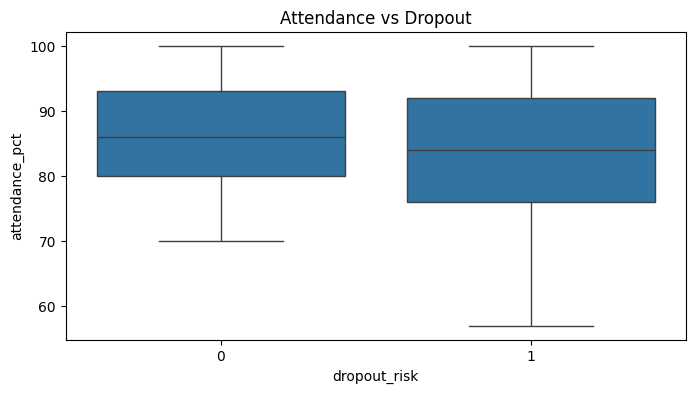

In [124]:
# Attendance vs Dropout Rate
plt.figure(figsize=(8,4))
sns.boxplot(x='dropout_risk', y='attendance_pct', data=data)
plt.title("Attendance vs Dropout")
plt.show()

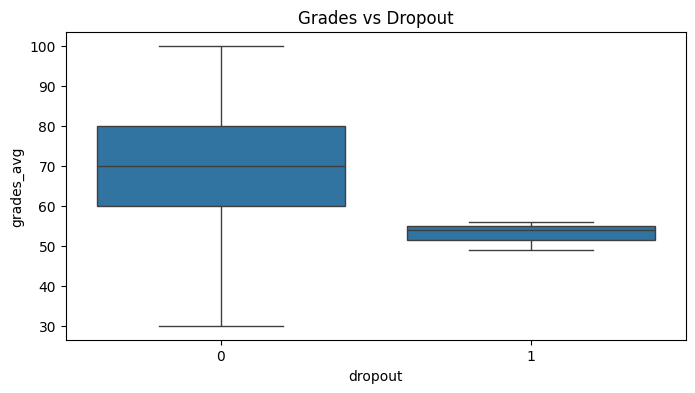

In [91]:
# Grades vs Dropout Rate
plt.figure(figsize=(8,4))
sns.boxplot(x='dropout', y='grades_avg', data=data)
plt.title("Grades vs Dropout")
plt.show()

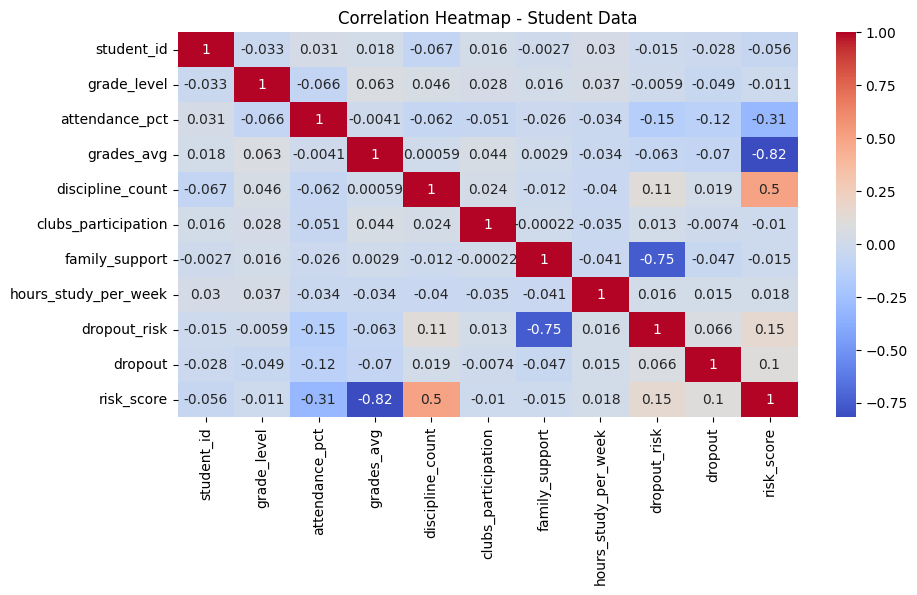

In [92]:
plt.figure(figsize=(10,5))
sns.heatmap(data.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap - Student Data")
plt.show()


### 4. Building a Model

In [94]:
X = data[['grade_level', 'attendance_pct', 'grades_avg', 'discipline_count', 
          'clubs_participation', 'family_support', 'hours_study_per_week']]
y = data['dropout']


In [133]:
#Scale my data
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)


In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [135]:
#Logistic Regression (No Regularisation)
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(PolynomialFeatures(degree=1), LogisticRegression(penalty=None, solver='lbfgs'))
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy")
print(scores, scores.mean())

[0.9765625 1.        1.        0.9921875 0.9921875] 0.9921875


In [136]:
# Support vector classification - RBF Kernel
from sklearn.svm import SVC

pipe = make_pipeline(PolynomialFeatures(degree=2), SVC(kernel='rbf',C=25))
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy")
print(scores, scores.mean())

[1.        1.        1.        0.9921875 0.9921875] 0.996875


In [137]:
# Support vector classification - Poly Kernel
pipe = make_pipeline(PolynomialFeatures(degree=1), SVC(kernel='poly',C=5))
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy")
print(scores, scores.mean())

[0.984375  0.984375  1.        0.9921875 0.9921875] 0.990625


In [138]:
# Support vector classification - Linear Kernel
from sklearn.svm import LinearSVC
pipe = make_pipeline(PolynomialFeatures(degree=2), LinearSVC(C=50))
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy")
print(scores, scores.mean())

[0.9921875 0.9921875 1.        0.9921875 0.9921875] 0.99375


In [139]:
# classification - Random Forest
pipe = make_pipeline(PolynomialFeatures(degree=1),RandomForestClassifier(n_estimators=1000,max_depth=10,criterion='gini'))
scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy")
print(scores, scores.mean())

[1.        1.        1.        0.9921875 0.9921875] 0.996875


### 5. Select the best model

In [140]:
#select the best model (Random Forest in this case)
best_model = make_pipeline(PolynomialFeatures(degree=1),RandomForestClassifier(n_estimators=1000,max_depth=10,criterion='gini'))
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)


Accuracy: 99.38%


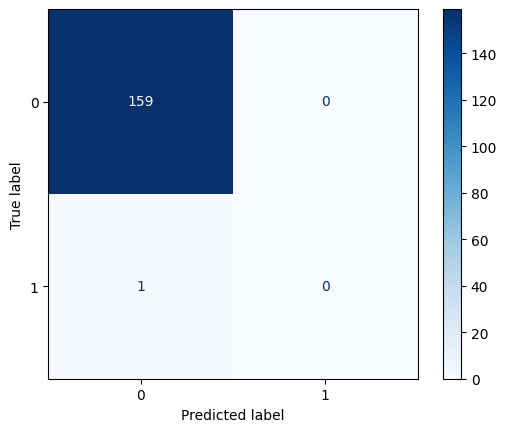

In [142]:
# Evaluate my model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


Recall: 0.00%


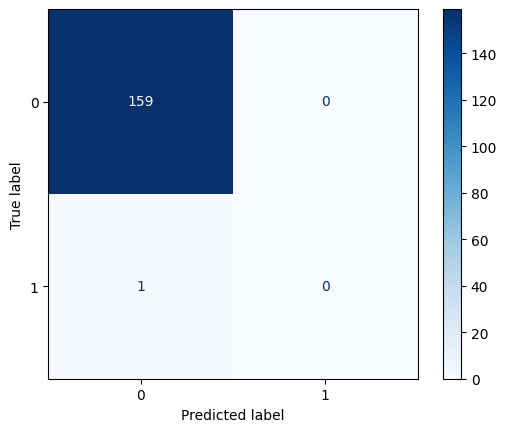

Precision: 0.00%
F1 Score: 0.00%


['student_dropout_model.pkl']

In [ ]:
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall *100 :.2f}%')

precision = precision_score(y_test, y_pred)
print(f'Precision: {precision *100 :.2f}%')

f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1 *100 :.2f}%') 



### 6. Feature Importance 

In [146]:
features = X_train.columns

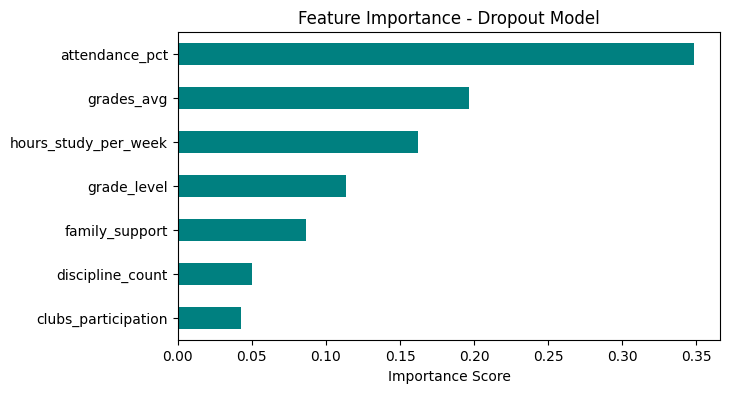

In [ ]:
importances = pd.Series(best_model.feature_importances_, index=features).sort_values(ascending=True)
plt.figure(figsize=(7,4))
importances.plot(kind='barh', color='teal')
plt.title("Feature Importance - Dropout Model")
plt.xlabel("Importance Score")
plt.show()

In [153]:
# Save the model
joblib.dump(best_model, 'student_dropout_model.pkl')
joblib.dump(scaler, "scaler.pkl")

data.to_csv("student_droput_data.csv", index=False)

print("Model and data saved: student_dropout_model.pkl, scaler.pkl, student_dropout_data.csv")


Model and data saved: student_dropout_model.pkl, scaler.pkl, student_dropout_data.csv


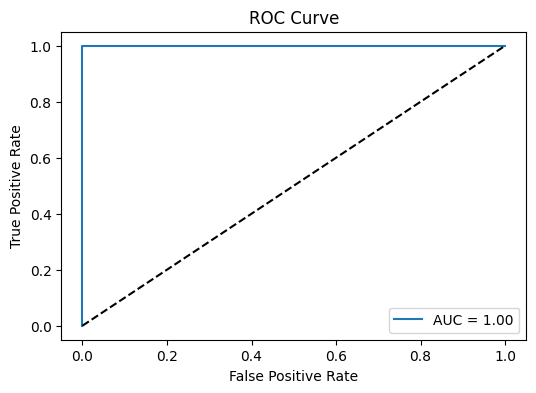

Model AUC Score: 1.000
Model performance acceptable for deployment.


In [155]:
#  Model Testing Before Deployment
from sklearn.metrics import roc_auc_score, roc_curve

y_probs = best_model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_probs)

fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print(f"Model AUC Score: {auc:.3f}")
if auc > 0.8:
    print("Model performance acceptable for deployment.")
else:
    print("Model needs improvement before deployment.")